## Exploratory data analysis on Tyler
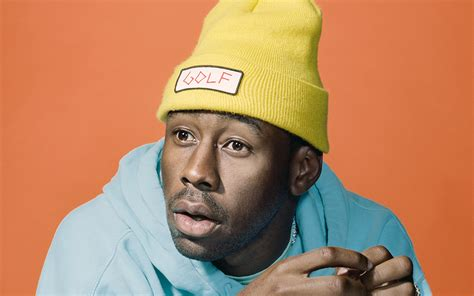

I based the data analysis I do here in the tutorial in this [article](https://stmorse.github.io/journal/spotify-api.html). Thanks to Steven Morse for his well-written post!

In [8]:
import spotify
import requests
import json
import pandas as pd
import numpy as np

In [1]:
import keys
# generate your own Spotify 🔑 and store it in a .py script in the same folder as this file
# name your ID CLIENT_ID and your secret CLIENT_SECRET (or modify the variable names)

Spotify uses a REST API service for their public API. You need a POST command for generic authentication to the API using a unique client ID and secret linked to your profile.

In [5]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': keys.CLIENT_ID,
    'client_secret': keys.CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

# set header now so we can use it later to access data
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

Next, we need the unique identifier for the track. We're analyzing a single song at first: Tyler's 2019 smash hit *EARFQUAKE*. 

You can easily replace this with the URI for another track by going to Spotify on your computer, clicking on the three dots next to a song and going to Share, then holding down the Alt key on Windows/Option key on Mac and choosing "Copy Spotify URI".

In [6]:
# EARFQUAKE track ID from the URI
track_id = '5hVghJ4KaYES3BFUATCYn0'

# actual GET request with proper header
r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)
r = r.json()

In [11]:
print(json.dumps(r, sort_keys=True, indent=4))

{
    "acousticness": 0.23,
    "analysis_url": "https://api.spotify.com/v1/audio-analysis/5hVghJ4KaYES3BFUATCYn0",
    "danceability": 0.554,
    "duration_ms": 190067,
    "energy": 0.498,
    "id": "5hVghJ4KaYES3BFUATCYn0",
    "instrumentalness": 5.98e-06,
    "key": 9,
    "liveness": 0.795,
    "loudness": -8.866,
    "mode": 1,
    "speechiness": 0.0685,
    "tempo": 79.635,
    "time_signature": 4,
    "track_href": "https://api.spotify.com/v1/tracks/5hVghJ4KaYES3BFUATCYn0",
    "type": "audio_features",
    "uri": "spotify:track:5hVghJ4KaYES3BFUATCYn0",
    "valence": 0.413
}


Next, we pull all data for Tyler the Creator from Spotify.

In [14]:
artist_id = '4V8LLVI7PbaPR0K2TGSxFF'

# pull data for all albums
r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50})
d = r.json()

In [15]:
for album in d['items']:
    print(album['name'], ' --- ', album['release_date'])

CALL ME IF YOU GET LOST  ---  2021-06-25
IGOR  ---  2019-05-17
Flower Boy  ---  2017-07-21
Cherry Bomb  ---  2015-04-13
Cherry Bomb + Instrumentals  ---  2015-04-13
Live At Splash!  ---  2013-09-02
Wolf  ---  2013-04-01
Goblin  ---  2011-05-09
Goblin  ---  2011-05-09
Goblin  ---  2011-05-09
Goblin  ---  2011-05-09


Tyler only has six albums, but we retrieved 11! There are duplicates of some albums, so we need to remove the duplicate data. Time for some data cleaning.

In [26]:
data = []   # will hold all track info
albums = [] # to keep track of duplicates

# loop over albums and get all tracks
for album in d['items']:
    album_name = album['name']

    # none of Tyler's original albums contain punctuation
    if (album_name in albums) or ('+' in album_name) or ('!' in album_name):
        continue
    albums.append(album_name)
    
    # this takes a few seconds so let's keep track of progress    
    print(album_name)
    
    # pull all tracks from this album
    r = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
    tracks = r.json()['items']
    
    for track in tracks:
        # get audio features (key, liveness, danceability, ...)
        f = requests.get(BASE_URL + 'audio-features/' + track['id'], 
            headers=headers)
        f = f.json()
        
        # combine with album info
        f.update({
            'track_name': track['name'],
            'album_name': album_name,
            'release_date': album['release_date'],
            'album_id': album['id']
        })
        
        data.append(f)

CALL ME IF YOU GET LOST
IGOR
Flower Boy
Cherry Bomb
Wolf
Goblin


In [27]:
# convert list of dicts into a dataframe
df = pd.DataFrame(data)

In [28]:
# convert release_date to an actual date, and sort by it
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

In [29]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,release_date,album_id
90,0.663,0.636,6,-9.768,0,0.355,0.0526,0.000000,0.272,0.280,...,54pBCKOljl7o5Vvy6bPns9,spotify:track:54pBCKOljl7o5Vvy6bPns9,https://api.spotify.com/v1/tracks/54pBCKOljl7o...,https://api.spotify.com/v1/audio-analysis/54pB...,202107,4,Steak Sauce,Goblin,2011-05-09,3CxknRPQLbOJRwQrNekNyU
73,0.456,0.529,5,-12.651,0,0.828,0.5340,0.000000,0.219,0.444,...,4Fp6Qaifzk3CCtggVJdWXT,spotify:track:4Fp6Qaifzk3CCtggVJdWXT,https://api.spotify.com/v1/tracks/4Fp6Qaifzk3C...,https://api.spotify.com/v1/audio-analysis/4Fp6...,408520,4,Goblin,Goblin,2011-05-09,3CxknRPQLbOJRwQrNekNyU
74,0.712,0.759,11,-5.397,1,0.334,0.0161,0.080800,0.217,0.738,...,3WQlJpaUUbGtUqAskvGA7c,spotify:track:3WQlJpaUUbGtUqAskvGA7c,https://api.spotify.com/v1/tracks/3WQlJpaUUbGt...,https://api.spotify.com/v1/audio-analysis/3WQl...,249333,4,Yonkers,Goblin,2011-05-09,3CxknRPQLbOJRwQrNekNyU
75,0.562,0.680,1,-8.015,1,0.498,0.1540,0.095500,0.269,0.224,...,5PNGLS7gfCsJqMoZTskSZJ,spotify:track:5PNGLS7gfCsJqMoZTskSZJ,https://api.spotify.com/v1/tracks/5PNGLS7gfCsJ...,https://api.spotify.com/v1/audio-analysis/5PNG...,438333,4,Radicals,Goblin,2011-05-09,3CxknRPQLbOJRwQrNekNyU
76,0.350,0.621,8,-6.495,0,0.233,0.2560,0.000034,0.613,0.459,...,5WzfCu5fhgm7jv896EN1Md,spotify:track:5WzfCu5fhgm7jv896EN1Md,https://api.spotify.com/v1/tracks/5WzfCu5fhgm7...,https://api.spotify.com/v1/audio-analysis/5Wzf...,253387,4,She,Goblin,2011-05-09,3CxknRPQLbOJRwQrNekNyU


## time for data visualization

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

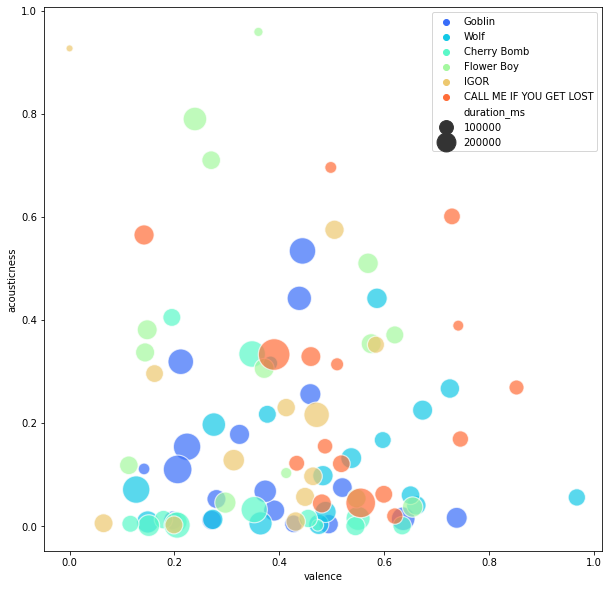

In [32]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=df, x='valence', y='acousticness', 
                     hue='album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)

## Dimensionality reduction

This is great for working with comparing two dimensions across all of Led Zeppelin's tracks, but for doing any more advanced kind of analysis, then we'd like to do dimensionality reduction. PCA is a good place to start, but it's limited in that the lower-dimensional surface you project your data onto is strictly linear (and most data is non-linear in higher dimensions). So let's try to learn a non-linear manifold using t-SNE (thanks Josh Tenenbaum).

In [33]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# extract relevant columns to numpy array
X = (df
 .filter(['acousticness', 'danceability', 'duration_ms', 'energy',
          'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence'])
)

# algo will do better if data is standardized (zero mean, unit variance)
Xs = StandardScaler().fit_transform(X)

In [41]:
# construct 2-d embedding
tsne = TSNE(n_components=2, perplexity=5, 
    early_exaggeration=2, random_state=3).fit_transform(Xs)

# convert to dataframe for plotting purposes
tsne = pd.DataFrame(tsne)
tsne['album_name'] = df['album_name']
tsne['duration_ms'] = df['duration_ms']
tsne.rename(columns = {0: "x", 1: "y"}, inplace = True)

In [42]:
tsne

,x,y,album_name,duration_ms
0,-4.225535,-43.242668,CALL ME IF YOU GET LOST,88625
1,41.153069,-95.867439,CALL ME IF YOU GET LOST,146482
2,-72.399231,69.047668,CALL ME IF YOU GET LOST,130980
3,-36.752163,-23.286272,CALL ME IF YOU GET LOST,121573
4,-42.385494,11.484719,CALL ME IF YOU GET LOST,138312
...,...,...,...,...
86,25.764122,-5.850872,Goblin,220253
87,-38.291809,-30.851398,Goblin,343280
88,-62.339462,46.756611,Goblin,229640
89,-76.146706,36.142502,Goblin,66933


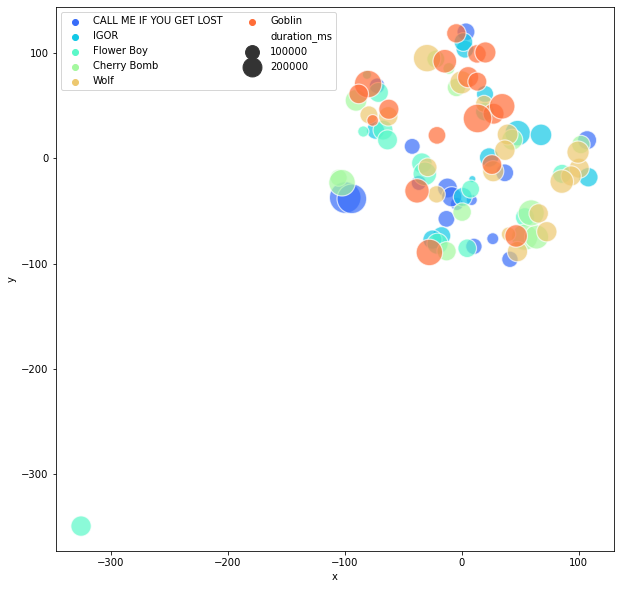

In [43]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=tsne, 
                     x="x", y="y", 
                     hue='album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', ncol=2)

plt.show()